# Titanic Survival Analysis And Visualization
In this notebook I use a random forest from the scikit learn package in order to predict whether each passenger on the titanic surived or perished.
<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To start the analysis, I look at the head of the data and a couple summaries.

In [2]:
df = pd.read_csv('../datasets/titanicData/train.csv', header=0)
df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [3]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
df.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


This last command was a statistical summary. A few of the columns were excluded because they were not numerical. This includes the sex column, which can be converted to a binary integer value so that it can be included in later analysis.

In [10]:
# Convert the categorical variable for sex into a binary integer
df['Gender'] = df.Sex.map({'female':0, 'male':1}).astype(int)

There are some NaNs in the Age column. I will be filling these in with plausible estimates. First I want to get a look at the age distribution and see if there is anything that might help me with deciding how to fill in the NaNs.

### Some visualizations

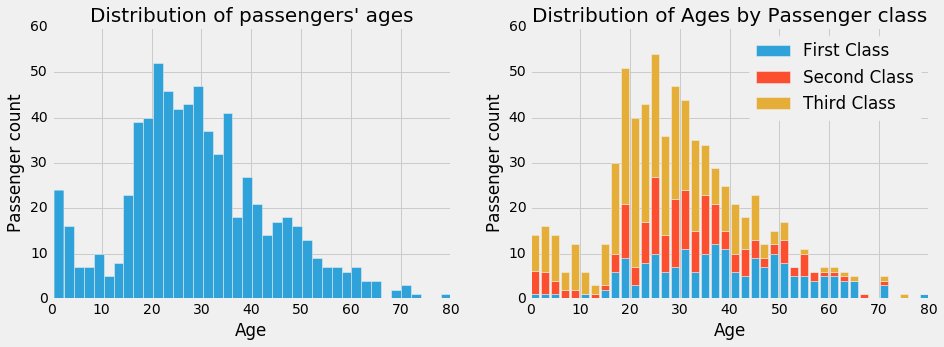

In [11]:
# Visualizing age distribution

plt.style.use(['fivethirtyeight'])
plt.figure(figsize=(14,10))
plt.subplot(221)
df.Age.plot.hist(bins=40)
plt.title("Distribution of passengers' ages", fontsize=20)
plt.ylabel('Passenger count')
plt.xlabel('Age')

plt.subplot(222)
plt.hist(x=[df.Age[df.Pclass==1], df.Age[df.Pclass==2], df.Age[df.Pclass==3]],
                       bins=40, range=(0,80), histtype='bar', stacked=True,
                            label=['First Class', 'Second Class', 'Third Class'])
plt.legend()
plt.title("Distribution of Ages by Passenger class", fontsize=20)
plt.ylabel('Passenger count')
plt.xlabel('Age')

This looks like a log-normal distribution or a right-skewed normal. The left side of the distribution looks strange--for some reason there are comparatively few older children and younger teens. For the rest of the analysis, I will assume that the missing age values are dominated by this group.


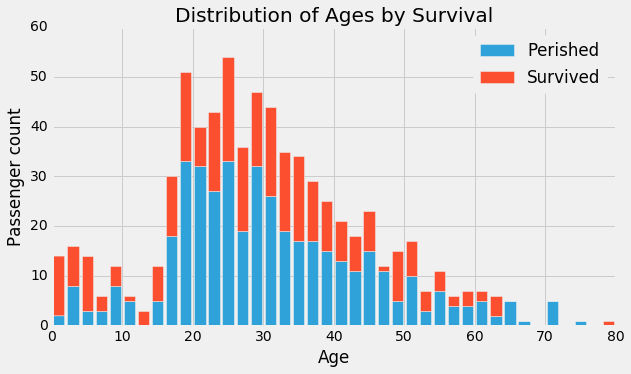

In [12]:
# I'm interested in how survival is distributed across different ages.
plt.figure(figsize=(9,5))
plt.hist(x=[df.Age[df.Survived==0], df.Age[df.Survived==1]], bins=40, range=(0,80),
         histtype='bar', stacked=True, label=["Perished","Survived"])
plt.ylabel("Passenger count")
plt.xlabel("Age")
plt.legend()
plt.title("Distribution of Ages by Survival")

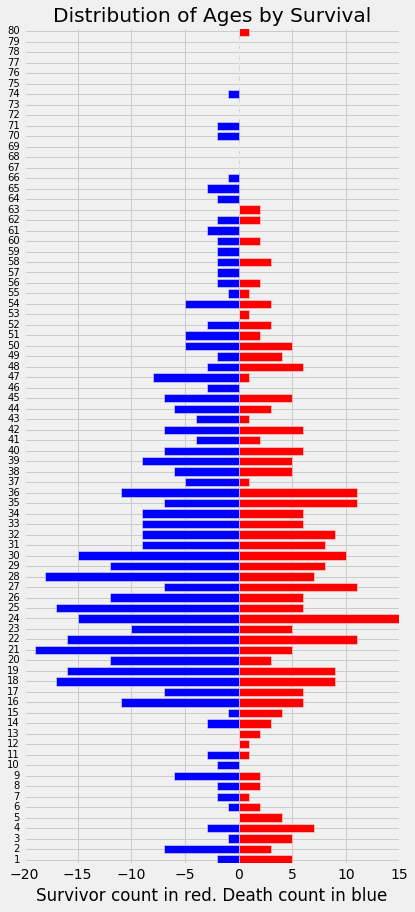

In [13]:
# Rearrangement of the above, with more bins
x0 = df.Age
x1 = x0[df.Survived==1].value_counts()
x2 = x0[df.Survived==0].value_counts()
dfx = pd.DataFrame(data={"x1":x1,
                         "x2":x2},
                   index=range(1,81))
dfx = dfx.fillna(0)
x1 = dfx.x1
x2 = dfx.x2

fig = plt.figure(figsize=(6,14))

y_pos = range(1,81)
y_pos = [x for x in y_pos]
plt.yticks(y_pos, fontsize=10)

plt.barh(y_pos, x1, align='center', color='#211b8')
plt.barh(y_pos, -x2, align="center", color='blue')

# plt.ylim([-1,len(x0)+0.1])
# plt.xlim([-max(x2)-10, max(x1)+10])


plt.xlabel('Survivor count in red. Death count in blue')
plt.title("Distribution of Ages by Survival")

### Feature engineering: NA ages

In [14]:
# Getting a glimpse of what the gender and class distribution is like for the Age NaNs
theAgeless = df[df.Age.isnull()][['Age','Sex','Gender','Pclass','Fare']]

theAgeless.head(15)

,Age,Sex,Gender,Pclass,Fare
5,NaN,male,1,3,8.4583
17,NaN,male,1,2,13.0000
19,NaN,female,0,3,7.2250
26,NaN,male,1,3,7.2250
28,NaN,female,0,3,7.8792
29,NaN,male,1,3,7.8958
31,NaN,female,0,1,146.5208
32,NaN,female,0,3,7.7500
36,NaN,male,1,3,7.2292
42,NaN,male,1,3,7.8958


In [15]:
print(theAgeless.describe())

       Age      Gender      Pclass        Fare
count  0.0  177.000000  177.000000  177.000000
mean   NaN    0.700565    2.598870   22.158567
std    NaN    0.459310    0.763216   31.874608
min    NaN    0.000000    1.000000    0.000000
25%    NaN    0.000000    3.000000    7.750000
50%    NaN    1.000000    3.000000    8.050000
75%    NaN    1.000000    3.000000   24.150000
max    NaN    1.000000    3.000000  227.525000


([<matplotlib.axis.XTick at 0x1191a1b50>,
 <a list of 3 Text xticklabel objects>)

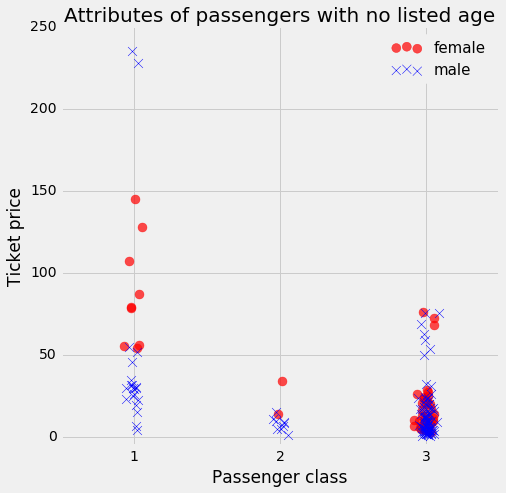

In [16]:
# Visualizing the above

def rand_jitter(arr, coeff):
    stdev = coeff*(max(arr)-min(arr))
    return abs(arr + np.random.randn(len(arr)) * stdev)

plt.figure(figsize=(7,7))
plt.scatter(rand_jitter(theAgeless[theAgeless.Gender==0]['Pclass'], coeff=0.015),
            rand_jitter(theAgeless[theAgeless.Gender==0]['Fare'], coeff=0.03), color='red', 
            alpha=0.7, label="female", s=80, marker='o')
plt.scatter(rand_jitter(theAgeless[theAgeless.Gender==1]['Pclass'], coeff=0.015), 
            rand_jitter(theAgeless[theAgeless.Gender==1]['Fare'], coeff=0.03), color='blue',
            alpha=1,label="male", s=80, marker='x')

plt.xlabel("Passenger class", fontsize=17)
plt.ylabel("Ticket price", fontsize=17)
plt.legend(loc='upper right', fontsize=15)
plt.title("Attributes of passengers with no listed age", fontsize=20)
plt.ylim([-5,250])
plt.xticks(range(1,4))

In [17]:
# I'm guessing that a lot of the missing ages are from children. Create a list of such guesses,
# sorted by passenger class.
presumed_ages = np.array([10,5,1])
presumed_ages

array([10,  5,  1])

In [18]:
# Make an indicator variable and a fill variable for missing ages
df['Age_is_null'] = df.Age.isnull().astype(int)
df['Age_fill'] = df.Age
df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Age_is_null,Age_fill
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,35.0


In [19]:
# Turn all NAs in Age_fill into the presumed age of that passenger's class.
for j in range(0,3):
    df.loc[(df.Age.isnull()) & (df.Pclass==j+1),
          'Age_fill'] = presumed_ages[j]

df[df['Age'].isnull()][['Gender','Pclass','Age','Age_fill']].head(10)

,Gender,Pclass,Age,Age_fill
5,1,3,NaN,1.0
17,1,2,NaN,5.0
19,0,3,NaN,1.0
26,1,3,NaN,1.0
28,0,3,NaN,1.0
29,1,3,NaN,1.0
31,0,1,NaN,10.0
32,0,3,NaN,1.0
36,1,3,NaN,1.0
42,1,3,NaN,1.0


In [20]:
sum(df.Age_fill.isnull())

0

In [21]:
# how bad is the NA problem in Embarked?
sum(df.Embarked.isnull())

2

In [22]:
# I want to know the features of the two cases of missing Embarked
df[df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Age_is_null,Age_fill
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,0,38.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,0,62.0


In [23]:
# Now fill in the two missing values in Embarked. Glancing at part of the raw dataframe,
# it looks like the most expensive tickets (such as these two) come from port C
df.loc[df.Embarked.isnull(),'Embarked'] = 'C'

In [24]:
# Add dummy variables for different ports
df['Embarked_S'] = df.Embarked.dropna().map({'S':1, 'C':0, 'Q':0}).astype(int)
df['Embarked_C'] = df.Embarked.dropna().map({'S':0, 'C':1, 'Q':0}).astype(int)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Gender         891 non-null int64
Age_is_null    891 non-null int64
Age_fill       891 non-null float64
Embarked_S     891 non-null int64
Embarked_C     891 non-null int64
dtypes: float64(3), int64(9), object(5)
memory usage: 118.4+ KB


### Culling Features
I'm going to remove reduntant and unhelpful features before the analysis.

In [26]:
# Identify non-numerical columns
df.dtypes[df.dtypes=='object'].index

Index([u'Name', u'Sex', u'Ticket', u'Cabin', u'Embarked'], dtype='object')

In [27]:
# Drop unhelpful columns
df = df.drop(['Name','Sex','Ticket','Cabin','Embarked'], axis=1)
df = df.drop('Age',axis=1)
df = df.drop('PassengerId',axis=1)

In [28]:
# Sanity check
df1 = df.dropna()
print(df.shape, df1.shape)

((891, 10), (891, 10))


In [29]:
df.head(3)

,Survived,Pclass,SibSp,Parch,Fare,Gender,Age_is_null,Age_fill,Embarked_S,Embarked_C
0,0,3,1,0,7.2500,1,0,22.0,1,0
1,1,1,1,0,71.2833,0,0,38.0,0,1
2,1,3,0,0,7.9250,0,0,26.0,1,0


## Random Forest

In [30]:
# Random forest requires training data to be numpy array of floats
train_data = df.values
train_data

array([[  0.,   3.,   1., ...,  22.,   1.,   0.],
       [  1.,   1.,   1., ...,  38.,   0.,   1.],
       [  1.,   3.,   0., ...,  26.,   1.,   0.],
       ..., 
       [  0.,   3.,   1., ...,   1.,   1.,   0.],
       [  1.,   1.,   0., ...,  26.,   0.,   1.],
       [  0.,   3.,   0., ...,  32.,   0.,   0.]])

In [31]:
train_data = train_data.astype(np.float32)

In [32]:
# Same for test data
testdf = pd.read_csv('../datasets/titanicData/test.csv', header=0)

In [33]:
ids = testdf['PassengerId'].values # saving so that it can be removed from the dataframe

In [34]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [35]:
print(sum(testdf.Embarked.isnull()), sum(testdf.Age.isnull()), sum(testdf['Sex'].isnull()))
#checking

(0, 86, 0)


In [36]:
# break out the Embarked feature into a pair of dummy variables
testdf['Embarked_S'] = testdf.Embarked.map({'S':1, 'C':0, 'Q':0}).astype(int)
testdf['Embarked_C'] = testdf.Embarked.map({'S':0, 'C':1, 'Q':0}).astype(int)

In [37]:
testdf['Gender'] = testdf.Sex.map({'female':0,'male':1}).astype('int')

In [38]:
testdf['Age_fill'] = testdf.Age

In [39]:
testdf['Age_is_null'] = testdf.Age.isnull().astype(int)

In [40]:
testdf.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_S,Embarked_C,Gender,Age_fill,Age_is_null
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,34.5,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0,0,47.0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,1,62.0,0


In [41]:
# replace NaNs in Age_fill with the most common age for each class
for j in range(0,3):
    testdf.loc[(testdf.Age.isnull()) & (testdf.Pclass==j+1),'Age_fill'] = presumed_ages[j]

In [42]:
# replace missing fares with the median for each Pclass
median_fares = np.zeros(3)
for j in range(0,2):
    median_fares[j] = testdf[testdf.Pclass==j+1]['Fare'].dropna().mode()[0]
for j in range(0,2):
    testdf.loc[testdf.Fare.isnull() & testdf.Pclass==j+1, 'Fare'] = median_fares[j]

In [43]:
# drop non-numeric columns
testdf = testdf.drop(['PassengerId','Name','Sex','Ticket','Cabin','Embarked'], axis=1)
# drop Age column in favor of Age_fill
testdf = testdf.drop('Age', axis=1)

In [44]:
# sanity check
print(testdf.shape, testdf.dropna().shape)

((418, 9), (418, 9))


In [45]:
test_data = testdf.values
test_data = test_data.astype(np.float32) # required for use in random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(train_data[0::,1::], train_data[0::,0])

In [48]:
output = forest.predict(test_data)

In [49]:
import csv
predictions_file = open('mythirdforest.csv','wb')
open_predictions_file = csv.writer(predictions_file)
open_predictions_file.writerow(['PassengerId','Survived'])
open_predictions_file.writerows(zip(ids,output.astype(int)))
predictions_file.close()
print('done')

done


### Result
The accuracy score for this prediction was 0.59330. For comparison, a model that assumes all passengers perish has a score of 0.62679.
I will drop all attributes except gender, class, and ticket price to see what the simpler model does for accuracy.

In [50]:
testdf.head()

,Pclass,SibSp,Parch,Fare,Embarked_S,Embarked_C,Gender,Age_fill,Age_is_null
0,3,0,0,7.8292,0,0,1,34.5,0
1,3,1,0,7.0000,1,0,0,47.0,0
2,2,0,0,9.6875,0,0,1,62.0,0
3,3,0,0,8.6625,1,0,1,27.0,0
4,3,1,1,12.2875,1,0,0,22.0,0


In [51]:
testdf2 = testdf.drop(["SibSp", "Parch", "Embarked_S", "Embarked_C", "Age_fill", "Age_is_null"], axis=1)
testdf2.head(2)

,Pclass,Fare,Gender
0,3,7.8292,1
1,3,7.0000,0


In [52]:
df2 = df.drop(["SibSp","Parch","Age_is_null","Age_fill","Embarked_S","Embarked_C"],axis=1)

In [53]:
df2.head(2)

,Survived,Pclass,Fare,Gender
0,0,3,7.2500,1
1,1,1,71.2833,0


In [54]:
train_data2 = np.array(df2)

In [55]:
test_data2 = np.array(testdf2)

In [56]:
forest2 = RandomForestClassifier(n_estimators=100)
forest2 = forest.fit(train_data2[0::,1::], train_data2[0::,0])

In [57]:
output2 = forest2.predict(test_data2)

In [58]:
predictions_file2 = open('myfourthforest.csv','wb')
open_predictions_file2 = csv.writer(predictions_file2)
open_predictions_file2.writerow(['PassengerId','Survived'])
open_predictions_file2.writerows(zip(ids,output2.astype(int)))
predictions_file2.close()
print('done')

done


### New Result
This prediction had an accuracy score of 0.76555. So for more than 75% of the passengers, the stripped-down random forest model correctly predicted whether they survived or perished. This is a substantial improvement.